In [19]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf

from time import time
from operator import itemgetter

from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

PLOT = True
SELECT_YEAR = 2017

DATA_PATH = '../data'
PLOT_PATH = '../docs/plots'


In [2]:
# Data Read
data_file = '{}/{}_lattes.pkl.xz'.format(DATA_PATH, SELECT_YEAR)
%time df = pd.read_pickle(data_file, compression='xz')
print('{} docs shape'.format(df.shape))
df.head(5)

CPU times: user 183 ms, sys: 19 ms, total: 202 ms
Wall time: 205 ms
(8652, 5) docs shape


id                                             titulo  \
79   104124422364023  Exploiting photo location and direction for cl...   
80   104124422364023  A gold-standard social media corpus for urban ...   
94   104124422364023  A Framework for Spatial Analytics using Hetero...   
140  105670521813027  Gene expression analysis in Musa acuminata dur...   
141  105670521813027  Mitogenome sequence accuracy using different e...   

                                                 clean  wct  wcc  
79   [exploit, photo, locat, direct, cluster, base,...    9    9  
80   [gold, standard, social, media, corpus, urban,...    8    7  
94   [framework, spatial, analyt, use, heterogen, d...    9    7  
140  [gene, express, analysi, musa, acuminata, comp...   12    9  
141  [mitogenom, sequenc, accuraci, use, differ, el...    7    7

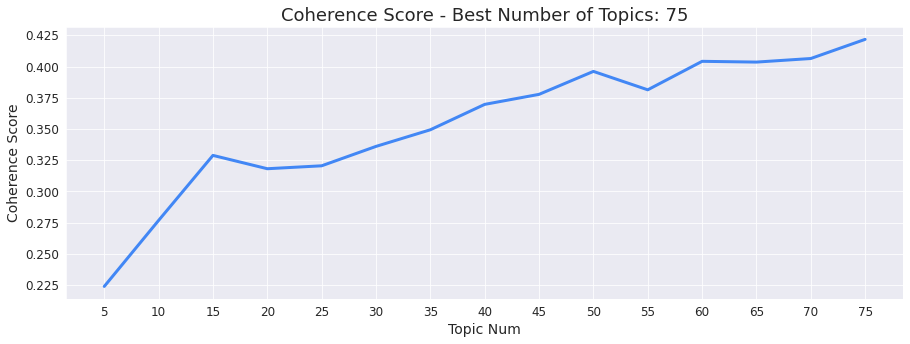

Time: 4.7 mins


In [3]:
# Use Gensim's NMF to get the best num of topics via coherence score

def graph_coherence(texts):
    # Create a dictionary
    # In gensim a dictionary is a mapping between words and their integer id
    dictionary = Dictionary(texts)

    # Filter out extremes to limit the number of features
    dictionary.filter_extremes(no_below=3, no_above=0.85, keep_n=5000)

    # Create the bag-of-words format (list of (token_id, token_count))
    corpus = [dictionary.doc2bow(text) for text in texts]

    # Create a list of the topic numbers we want to try
    topic_nums = list(np.arange(5, 75 + 1, 5))

    # Run the nmf model and calculate the coherence score
    # for each number of topics
    coherence_scores = []

    for num in topic_nums:
        nmf = Nmf(
            corpus=corpus,
            num_topics=num,
            id2word=dictionary,
            chunksize=2000,
            passes=5,
            kappa=.1,
            minimum_probability=0.01,
            w_max_iter=300,
            w_stop_condition=0.0001,
            h_max_iter=100,
            h_stop_condition=0.001,
            eval_every=10,
            normalize=True,
            random_state=42
        )
        
        # Run the coherence model to get the score
        cm = CoherenceModel(
            model=nmf,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        
        coherence_scores.append(round(cm.get_coherence(), 5))

    # Get the number of topics with the highest coherence score
    scores = list(zip(topic_nums, coherence_scores))
    best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

    # Plot the results
    fig = plt.figure(figsize=(15, 5))

    plt.plot(topic_nums, coherence_scores, linewidth=3, color='#4287f5')

    plt.title('Coherence Score - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
    plt.xlabel("Topic Num", fontsize=14)
    plt.ylabel("Coherence Score", fontsize=14)
    plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
    plt.yticks(fontsize=12)

    file_name = '{}/{}_c_score.png'.format(PLOT_PATH,SELECT_YEAR)
    fig.savefig(file_name, dpi=fig.dpi, bbox_inches='tight')
    plt.show()

    return best_num_topics

if PLOT:
    t = time()
    texts = df['clean']
    best_num_topics = graph_coherence(texts)
    print('Time: {} mins'.format(round((time() - t) / 60, 2)))
else:
    best_num_topics = 20

In [4]:
# Create the tfidf
texts = df['clean']

tfidf_vectorizer = TfidfVectorizer(
    min_df=0.0025,
    max_df=0.8,
    max_features=5000,
    ngram_range=(1,3),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)
tfidf_fn = tfidf_vectorizer.get_feature_names()

print('vocabulary: {}'.format(len(tfidf_vectorizer.vocabulary_)))
print('sparse matrix shape: {}'.format(tfidf.shape))
print('nonzero count: {}'.format(tfidf.nnz))
print('sparsity: {:.3f}'.format(100.0 * tfidf.nnz / (tfidf.shape[0] * tfidf.shape[1])))

weights = np.asarray(tfidf.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tfidf_vectorizer.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)



vocabulary: 754
sparse matrix shape: (8652, 754)
nonzero count: 52506
sparsity: 0.805


term    weight
59        base  0.030032
723        use  0.028436
419      model  0.025023
663     system  0.023610
26     analysi  0.022207
442    network  0.021797
163       data  0.018569
32    approach  0.016816
651      studi  0.014958
362      learn  0.014701
19   algorithm  0.014446
619    softwar  0.013533
31      applic  0.013292
234      evalu  0.012891
505    problem  0.012563
408     method  0.012165
182     detect  0.011820
507    process  0.011577
127     comput  0.011191
462      optim  0.011172

In [5]:
# Run the nmf model
nmf = NMF(
    n_components=20,
    #n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=42
).fit(tfidf)

def list_topics(model, feature_names, no_top_words):
    idx2word = np.array(feature_names)
    for i, topic in enumerate(model.components_):
        print('{:02d}: {}'.format(
            i + 1, ','.join([x for x in idx2word[topic.argsort()[:-no_top_words - 1:-1]]])))

list_topics(nmf,tfidf_fn,8)

01: use,predict,techniqu,improv,estim,measur,identif,classif
02: network,neural,neural network,wireless,sensor,wireless sensor,sensor network,wireless sensor network
03: model,simul,process,model base,busi,base model,predict,ontolog
04: system,distribut,architectur,inform,multi,support,monitor,inform system
05: base,featur,method,model base,base approach,base model,framework,agent
06: analysi,compar,interact,genom,brazilian,social,effect,social network
07: softwar,develop,softwar develop,product,process,engin,project,line
08: algorithm,problem,genet,genet algorithm,heurist,parallel,hybrid,schedul
09: data,mine,data mine,stream,data stream,big,visual,big data
10: learn,machin,machin learn,environ,educ,learn environ,deep,deep learn
11: studi,case,case studi,brazilian,brazil,code,exploratori,compar studi
12: evalu,perform,improv,perform evalu,impact,automat,high,method
13: approach,base approach,new,approach base,generat,classif,learn approach,visual
14: detect,imag,method,automat,segment

In [6]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["T%d_words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["T%d_wgt" % (topic_idx)]= ['{:.3f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

display_topics(nmf,tfidf_fn,10)


T0_words T0_wgt                 T1_words T1_wgt    T2_words T2_wgt  \
0       use  9.514                  network  2.727       model  2.503   
1   predict  0.931                   neural  0.851       simul  0.269   
2  techniqu  0.699           neural network  0.825     process  0.196   
3    improv  0.573                 wireless  0.538  model base  0.175   
4     estim  0.571                   sensor  0.450        busi  0.147   
5    measur  0.547          wireless sensor  0.395  base model  0.140   
6   identif  0.541           sensor network  0.391     predict  0.138   
7   classif  0.461  wireless sensor network  0.352     ontolog  0.107   
8        3d  0.430                 convolut  0.331   framework  0.106   
9    featur  0.379          convolut neural  0.300       estim  0.099   

        T3_words T3_wgt       T4_words T4_wgt  ...                  T15_words  \
0         system  2.838           base  3.319  ...                   systemat   
1      distribut  0.215         featur  0.205  ...                     review   
2    architectur  0.191         method  0.199  ...                  literatur   
3         inform  0.175     model base  0.174  ...           literatur review   
4          multi  0.175  base approach  0.156  ...                        map   
5        support  0.168     base model  0.155  ...            systemat review   
6        monitor  0.152      framework  0.152  ...         systemat literatur   
7  inform system  0.136          agent  0.134  ...  systemat literatur review   
8      recommend  0.131  approach base  0.133  ...               systemat map   
9          agent  0.129       platform  0.132  ...                     method   

  T15_wgt  T16_words T16_wgt     T17_words T17_wgt            T18_words  \
0   1.353       time   1.721        comput   2.069                optim   
1   1.332    control   1.412         cloud   1.044                multi   
2   0.807       real   0.826  cloud comput   0.596               object   
3   0.649  real time   0.785       environ   0.488         multi object   
4   0.645       seri   0.445        servic   0.382                swarm   
5   0.586      simul   0.444         secur   0.273              particl   
6   0.582  time seri   0.428       perform   0.198        particl swarm   
7   0.573   forecast   0.213       virtual   0.195          swarm optim   
8   0.426      video   0.178          awar   0.160  particl swarm optim   
9   0.268   strategi   0.174   architectur   0.159                 plan   

  T18_wgt  T19_words T19_wgt  
0   2.045      graph   2.390  
1   0.766       path   0.301  
2   0.663        edg   0.273  
3   0.386    process   0.228  
4   0.208      color   0.194  
5   0.205  threshold   0.186  
6   0.196    continu   0.165  
7   0.195       larg   0.157  
8   0.195   attribut   0.149  
9   0.178    databas   0.144  

[10 rows x 40 columns]

In [7]:
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist

def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  

def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)

docweights = nmf.transform(tfidf_vectorizer.transform(texts))

n_top_words = 8
topic_df = topic_table(nmf, tfidf_fn, n_top_words).T

topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(word_tokenize) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

topic_df.head()


0          1               2           3              4  \
0      use    predict        techniqu      improv          estim   
1  network     neural  neural network    wireless         sensor   
2    model      simul         process  model base           busi   
3   system  distribut     architectur      inform          multi   
4     base     featur          method  model base  base approach   

                 5               6                        7  \
0           measur         identif                  classif   
1  wireless sensor  sensor network  wireless sensor network   
2       base model         predict                  ontolog   
3          support         monitor            inform system   
4       base model       framework                    agent   

                                              topics  
0  use predict techniqu improv estim measur ident...  
1                     network neural wireless sensor  
2      model simul process base busi predict ontolog  
3  system distribut architectur inform multi supp...  
4  base featur method model approach framework agent

In [8]:
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

topic_df.head(10)

topic_num                                             topics
0          0  use predict techniqu improv estim measur ident...
1          1                     network neural wireless sensor
2          2      model simul process base busi predict ontolog
3          3  system distribut architectur inform multi supp...
4          4  base featur method model approach framework agent
5          5  analysi compar interact genom brazilian social...
6          6  softwar develop product process engin project ...
7          7  algorithm problem genet heurist parallel hybri...
8          8                        data mine stream big visual
9          9                     learn machin environ educ deep

In [9]:
df_temp = pd.DataFrame({
    'topic_num': docweights.argmax(axis=1)
})

# Merging to get the topic num with url
merged_topic = df_temp.merge(
    topic_df,
    on='topic_num',
    how='left'
)

# Merging with the original df
df_topics = pd.merge(
    df,
    merged_topic,
    left_index=True,
    right_index=True
)

df_topics = df_topics.drop(['clean','wct','wcc'],axis=1)
df_topics.head(10)


id                                             titulo  \
79   104124422364023  Exploiting photo location and direction for cl...   
80   104124422364023  A gold-standard social media corpus for urban ...   
94   104124422364023  A Framework for Spatial Analytics using Hetero...   
140  105670521813027  Gene expression analysis in Musa acuminata dur...   
141  105670521813027  Mitogenome sequence accuracy using different e...   
169  109837868064895  A study of equivalent electrical circuit fitti...   
210  116792663386170  DYNAMICS OF CONNECTED VESSELS WITH RUNAWAY REA...   
211  116792663386170  VLE BASED DYNAMIC SIMULATION OF A TRICKLE-BED ...   
212  116792663386170  SOLUBILITY BEHAVIOR OF GAMMA-VALEROLACTONE + N...   
242  116792663386170  Removal of amoxicillin from water by adsorptio...   

     topic_num                                             topics  
79          10  studi case brazilian brazil code exploratori c...  
80          15                      systemat review literatur map  
94           5  analysi compar interact genom brazilian social...  
140         18                   optim multi object swarm particl  
141          9                     learn machin environ educ deep  
169         16              time control real seri simul forecast  
210         16              time control real seri simul forecast  
211          8                        data mine stream big visual  
212         14     applic mobil design awar context cost iot test  
242         13  detect imag method automat segment featur proc...

In [10]:
# Showing the 3 matrices we get witn nmf
A = tfidf_vectorizer.transform(texts)
W = nmf.components_
H = nmf.transform(A)

print('A = {} x {}'.format(A.shape[0], A.shape[1]))
print('W = {} x {}'.format(W.shape[0], W.shape[1]))
print('H = {} x {}'.format(H.shape[0], H.shape[1]))

A = 8652 x 754
W = 20 x 754
H = 8652 x 20


In [11]:
# Get the residuals for each document
r = np.zeros(A.shape[0])

for row in range(A.shape[0]):
    r[row] = np.linalg.norm(A[row, :] - H[row, :].dot(W), 'fro')

sum_sqrt_res = round(sum(np.sqrt(r)), 3)
'Sum of the squared residuals is {}'.format(sum_sqrt_res)

'Sum of the squared residuals is 8271.873'

In [12]:
# Add the residuals to the df
df_topics['resid'] = r

# Get the avg residual by topic
resid_data = df_topics[[
    'topic_num',
    'resid'
]].groupby('topic_num').mean().sort_values(by='resid')

# Plot a bar chart for the avg. residuls by topic
fig = plt.figure(figsize=(20,7))

x = resid_data.index
y = resid_data['resid']
    
g = sns.barplot(
    x=x,
    y=y,
    order=x,
    palette='rocket'
)

g.set_xticklabels(
    g.get_xticklabels(),
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Topic Number', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.title('Avg. Residuals by Topic Number', fontsize=17)

file_name = '/{}_avg_resid'.format(SELECT_YEAR)

fig.savefig(
    PLOT_PATH + file_name + '.png',
    dpi=fig.dpi,
    bbox_inches='tight'
)

plt.show()

ValueError: Length of values does not match length of index

<Figure size 1080x504 with 0 Axes>

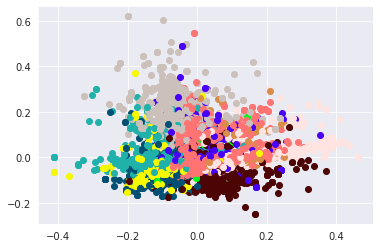

Time: 4.83 mins


In [13]:
# Create k-means model with custom config

def graph_KMeans(tfidf):
    num_clusters = 10
    num_seeds = 10
    max_iterations = 300
    labels_color_map = {
        0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404',
        5: '#ccc0ba', 6: '#4700f9', 7: '#f6f900', 8: '#00f91d', 9: '#da8c49'
    }
    pca_num_components = 2

    clustering_model = KMeans(
        n_clusters=num_clusters,
        max_iter=max_iterations,
        precompute_distances="auto",
        n_jobs=-1
    )

    labels = clustering_model.fit_predict(tfidf)

    X = tfidf.todense()

    reduced_data = PCA(n_components=pca_num_components).fit_transform(X)

    fig = plt.figure(figsize=(15, 7))

    fig, ax = plt.subplots()
    for index, instance in enumerate(reduced_data):
        pca_comp_1, pca_comp_2 = reduced_data[index]
        color = labels_color_map[labels[index]]
        ax.scatter(pca_comp_1, pca_comp_2, c=color)

    file_name = '{}/{}_KMeans.png'.format(PLOT_PATH,SELECT_YEAR)
    fig.savefig(file_name, dpi=fig.dpi, bbox_inches='tight')
    plt.show()

if PLOT:
    t = time()
    graph_KMeans(tfidf)
    print('Time: {} mins'.format(round((time() - t) / 60, 2)))

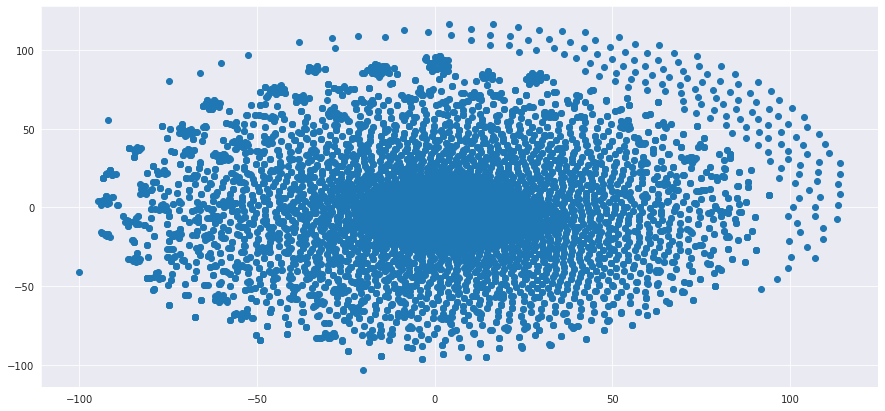

Time: 4.45 mins


In [14]:
# t-SNE plot

def graph_tsne(tfidf):
    X = tfidf.todense()
    tsne_num_components = 2
    embeddings = TSNE(n_components=tsne_num_components)
    Y = embeddings.fit_transform(X)

    fig = plt.figure(figsize=(15, 7))

    plt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)

    file_name = '{}/{}_tsne.png'.format(PLOT_PATH,SELECT_YEAR)
    fig.savefig(file_name, dpi=fig.dpi, bbox_inches='tight')
    plt.show()

if PLOT:
    t = time()
    graph_tsne(tfidf)
    print('Time: {} mins'.format(round((time() - t) / 60, 2)))


In [21]:
# Construct the k-means clusters
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(tfidf)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(tfidf)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.04  0.01  0.01 ...  0.01  0.02  0.01]
 [-0.01  0.    0.   ...  0.   -0.   -0.  ]]
Perc of Variance Explained: 
 [0.   0.01]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

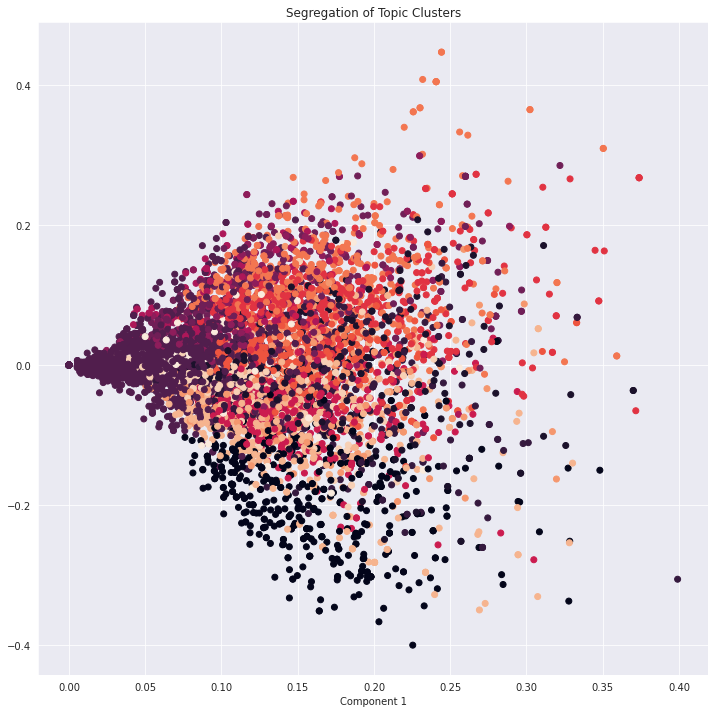

In [22]:
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [15]:
# Save
path = '{}/'.format(DATA_PATH)

topics_file = '{}/{}_topics.pkl.xz'.format(DATA_PATH, SELECT_YEAR)
%time df_topics.to_pickle(topics_file, compression='xz')

CPU times: user 29.7 ms, sys: 15.4 ms, total: 45.1 ms
Wall time: 45.6 ms
